# ME5413: Autonomous Mobile Robot  

### Homework 1: Perception  
Due date: 22 February 2024 (Thurs) - 2359 

### Task 1.1 Single-Object Tracking 

#### Preparation

**Import the necessary packages**

In [22]:
import cv2
import numpy as np
import glob
from utils.load import *
from utils.save import save_detections
from utils.evaluate import *

**Load (and Test) the original frames**

The original frames are stored in the folder `./data`. I define the variable `images` to store the original frames, and then use `cv2.imshow()` to display the original videos.

In [23]:
# parameters to be set
seq_index = "3"
is_limit_region = True
is_scale = True

# load the frames
seq_folder_path = 'data/seq_' + seq_index
image_files = glob.glob(seq_folder_path + '/img' + '/*.jpg')
image_files.sort()

images = []
for image_files in image_files:
    image = cv2.imread(image_files)
    images.append(image)

# # test the display
# for img in images:
#     cv2.imshow('image', img)
#     if cv2.waitKey(50) & 0xFF == ord('q'):
#         break

cv2.destroyAllWindows()

#### Using Kalman Filter based on Template Matching

**Initialize the template**

In [24]:
# Create a template from the first frame
x, y, w, h = load_firsttrack(seq_folder_path + '/firsttrack.txt')
template = images[0][y:y+h, x:x+w]

# Define a list of scales for resizing the template
wh_scales = []

# Define the extended region of template matching
limit_region = [100, 100, 100, 100] # [left, top, right, bottom]

# Definie the extended region of template matching
# Select matching method based on the seq_folder_path
if seq_folder_path == 'data/seq_1':
    matching_method = cv2.TM_CCOEFF_NORMED # TM_CCOEFF_NORMED > TM_CCORR_NORMED > TM_CCOEFF
    wh_scales = [[1.0, 1.0], [0.9, 1.0], [0.8, 1.0]]
    limit_region = [1, 5, 8, 1]
elif seq_folder_path == 'data/seq_2':
    matching_method = cv2.TM_SQDIFF_NORMED # TM_SQDIFF> TM_CCOEFF > TM_CCOEFF_NORMED > TM_SQDIFF_NORMED > TM_CCORR_NORMED
    wh_scales = [[1.0, 1.0], [1.0, 0.9], [0.9, 1.0]]
    limit_region = [50, 1, 10, 1]
elif seq_folder_path == 'data/seq_3':
    matching_method = cv2.TM_CCORR_NORMED
    wh_scales = [[1.0, 1.0]]
    limit_region = [5, 1, 8, 1]
elif seq_folder_path == 'data/seq_4':
    matching_method = cv2.TM_CCOEFF_NORMED
    wh_scales = [[1.0, 1.0]]
    limit_region = [1, 1, 50, 5]
elif seq_folder_path == 'data/seq_5':
    matching_method = cv2.TM_CCOEFF
    wh_scales = [[1.0, 1.0]]
    limit_region = [10, 10, 10, 10]
else:
    matching_method = cv2.TM_CCOEFF_NORMED  # Default method
    wh_scales = [[1.0, 1.0]]
    limit_region = [100, 100, 100, 100]

if not is_limit_region:
    limit_region = [1000, 1000, 1000, 1000]

if not is_scale:
    wh_scales = [[1.0, 1.0]]

**Initialize the Kalman Filter**

In [25]:
# Define the Kalman filter
kf = cv2.KalmanFilter(4, 2)

# Initial state (x, y, v_x, v_y) representing the center of the bounding box and the velocity
kf.statePre = np.array([x + w/2, y + h/2, 0, 0], dtype=np.float32)

# Transition matrix
kf.transitionMatrix = np.array([[1, 0, 1, 0],
                                [0, 1, 0, 1],
                                [0, 0, 1, 0],
                                [0, 0, 0, 1]], dtype=np.float32)

# Process noise covariance matrix
kf.processNoiseCov = np.array([[1, 0, 0, 0],
                               [0, 1, 0, 0],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]], dtype=np.float32) * 0.03

# Measurement matrix
kf.measurementMatrix = np.array([[1, 0, 0, 0],
                                 [0, 1, 0, 0]], dtype=np.float32)

# Measurement noise covariance matrix
kf.measurementNoiseCov = np.array([[1, 0],
                                   [0, 1]], dtype=np.float32) * 0.1

In [26]:
# Initialize the list to store the detections
detections = []

# Store the previous location
prev_loc = (x, y)

for img in images:
    # Initialize variables to store the best match
    best_match = None 
    best_val = -np.inf
    best_scale = (None, None)

    # Define the region for template matching
    x_region = max(0, prev_loc[0] - limit_region[0])
    y_region = max(0, prev_loc[1] - limit_region[1])
    w_region = min(img.shape[1] - 1, prev_loc[0] + w + limit_region[2]) - x_region
    h_region = min(img.shape[0] - 1, prev_loc[1] + h + limit_region[3]) - y_region

    for width_scale, height_scale in wh_scales:
        # Resize the template
        resized_template = cv2.resize(template, (0,0), fx=width_scale, fy=height_scale)

        # Template matching
        # res = cv2.matchTemplate(img, resized_template, matching_method)
        res = cv2.matchTemplate(img[y_region:y_region+h_region, x_region:x_region+w_region], resized_template, matching_method)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        max_loc = (max_loc[0] + x_region, max_loc[1] + y_region)

        # If this match is better than the previous best, update the best match
        if max_val > best_val:
            best_val = max_val
            best_match = max_loc
            best_scale = (width_scale, height_scale)

    # copy the image
    img_copy = img.copy()

    # Kalman filter prediction
    if best_match is not None:
        x, y = best_match
        w = int(template.shape[1] * best_scale[0])
        h = int(template.shape[0] * best_scale[1])

        # Update the Kalman filter
        kf.correct(np.array([x + w/2, y + h/2], dtype=np.float32))

        # Predict the next location
        prediction = kf.predict()
        x, y = prediction[0] - w/2, prediction[1] - h/2

        # Draw the bounding box
        cv2.rectangle(img_copy, (int(x), int(y)), (int(w*best_scale[0]), int(h*best_scale[1])), (0, 255, 0), 2)

        # Store the detection
        detections.append([int(x), int(y), int(w), int(h)])
    else:
        # If no match is found, store the previous location
        detections.append([int(prev_loc[0]), int(prev_loc[1]), int(w), int(h)])

cv2.destroyAllWindows()

# After processing all frames, save the detections to a text file
save_detections(detections,  seq_folder_path + '/detections_kf_tmbased.txt')

**Evaluate the performance of the Single object tracking algorithm.**

Evaluate the performance of template matching and Kalman filter. The evaluation should include the following:
+ The accuracy of the tracking algorithm
+ The robustness of the tracking algorithm
+ The efficiency of the tracking algorithm


In [27]:
# Load the ground truth and the detections
groundtruth = load_tracks(seq_folder_path + '/groundtruth.txt')
detections_kf = load_tracks(seq_folder_path + '/detections_kf_tmbased.txt')

# Return the average IoU
average_iou_kf = evaluate_average_iou(detections_kf, groundtruth)


**Visualise the results as well**.


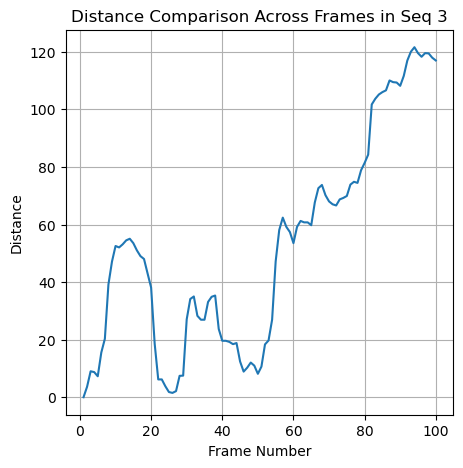

In [28]:
# visualize_iou(detections_tm, groundtruth, "IOU Comparison Across Frames in Seq " + seq_index)
visualize_distance(detections_kf, groundtruth, "Distance Comparison Across Frames in Seq " + seq_index)

Propose Improvements to the work if possible: